In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import pickle
import math

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

n_gpus = torch.cuda.device_count()
print(n_gpus)

cuda
1


In [3]:
with open('input.txt', 'r', encoding='utf-8') as f:
    data = f.read()
print("Size:{}".format(len(data)))

Size:1115393


In [4]:
# Create Token Set
charset = list(set(data))
charset.sort()
vocab_size = len(charset)
print("Size: {}".format(len(charset)))
print("Set:  {}".format(''.join(charset)))

Size: 65
Set:  
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [5]:
# Create token encoder / decoder
stoi = {ch:index for index, ch in enumerate(charset)}
itos = {index:ch for index, ch in enumerate(charset)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: [itos[i] for i in l]
enc = encode("helloworld")
dec = decode(enc)
print(dec)

['h', 'e', 'l', 'l', 'o', 'w', 'o', 'r', 'l', 'd']


In [6]:
torch.manual_seed(1337)
train_percent = 0.9

t = torch.tensor(encode(data), dtype=torch.long)
train_num = int(train_percent * t.shape[0])
train_data = t[:train_num]
val_data = t[train_num:]
print("TrainNum: {}".format(train_num))

TrainNum: 1003853


In [7]:
def create_dataset(t, block_size):
    length = t.shape[0] - block_size
    tensor_x = torch.arange(start=0, end=length)
    tensor_y = torch.arange(start=1, end=length+1)

    b = torch.arange(block_size).view(1, -1)
    x_view = tensor_x.view(-1, 1) + b
    x_data = t[x_view]

    y_view = tensor_y.view(-1, 1) + b
    y_data = t[y_view]
    
    return TensorDataset(x_data, y_data)

def create_data_loader(t, batch_size, block_size):
    dataset = create_dataset(t, block_size=block_size)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

#train_dl = create_data_loader(train_data, batch_size, block_size)
#val_dl = create_data_loader(val_data, batch_size, block_size)
# for xb, yb in train_dl:
#     print(xb)
#     print(yb)
#     break

In [8]:
class BigramModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_table = nn.Embedding(vocab_size, 32)
        self.linear = nn.Linear(32, vocab_size)
        
    def forward(self, x):
        # Create the logits
        embeddings = self.embedding_table(x)
        logits = self.linear(embeddings)
        
        return logits

    def generate(self, x, num_tokens=100):
        for _ in range(num_tokens):
            logits = self.forward(x) # logits is B, T, C
            logits_last_time_step = logits[:, -1, :]
            # print(logits.shape)
            # print(logits_last_time_step.shape)
        
            batch_probs = F.softmax(logits_last_time_step, dim=1)
            batch_next_ch = torch.multinomial(batch_probs, 1)
            x = torch.cat((x, batch_next_ch), dim=1) # B, T+1
        return x

In [9]:
class SingleHeadAttentionModule(nn.Module):
    def __init__(self, embedding_size, head_size):
        super().__init__()
        self.head_size = head_size
        self.q = nn.Linear(embedding_size, head_size, bias=False)
        self.k = nn.Linear(embedding_size, head_size, bias=False)
        self.v = nn.Linear(embedding_size, head_size, bias=False)
    
    def forward(self, query, key, value):
        query = self.q(query)
        key = self.k(key)
        value = self.v(value)
        
        att_mat = query @ torch.transpose(key, -2, -1)
        att_mat_scaled = torch.div(att_mat, torch.sqrt(torch.tensor(self.head_size)))
        
        att_mat_scaled[torch.tril(torch.ones_like(att_mat_scaled)) == 0.] = -float('inf')
        
        return att_mat_scaled.softmax(-1) @ value

In [10]:
class MultiHeadAttentionModule(nn.Module):
    def __init__(self, num_heads, embedding_size):
        super().__init__()
        assert num_heads != 0
        assert embedding_size % num_heads == 0
        
        self.heads = num_heads
        self.head_size = int(embedding_size / num_heads)
        
        self.q = nn.Linear(embedding_size, embedding_size, bias=False)
        self.k = nn.Linear(embedding_size, embedding_size, bias=False)
        self.v = nn.Linear(embedding_size, embedding_size, bias=False)
        
            
    def forward(self, query, key, value):
        query = self.q(query)
        key = self.k(key)
        value = self.v(value)
        
        # (batch_size, max_len, d_model) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.head_size).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.head_size).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.head_size).permute(0, 2, 1, 3)
        
        attn_scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))
        
        attn_scores[torch.tril(torch.ones_like(attn_scores)) == 0.] = -float('inf')
        
        context = attn_scores.softmax(-1) @ value
        
        return context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.head_size)

In [11]:
# class MultiHeadAttentionModule(nn.Module):
#     def __init__(self, num_heads, embedding_size):
#         super().__init__()
#         assert num_heads != 0
#         assert embedding_size % num_heads == 0
        
#         self.head_size = int(embedding_size / num_heads)
#         self.heads = nn.ModuleList([SingleHeadAttentionModule(embedding_size=embedding_size, head_size=self.head_size) for _ in range(1, num_heads+1)])
    
#     def forward(self, query, key, value):
#         return torch.cat([sahm(query, key, value) for sahm in self.heads], dim=-1)

In [12]:
class FeedForwardModule(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        
        self.layers = nn.Sequential(nn.Linear(embedding_size, 4 * embedding_size), 
                                    nn.ReLU(), 
                                    nn.Linear(4 * embedding_size, embedding_size), 
                                    nn.ReLU())
        
    def forward(self, x):
        return self.layers(x)

In [13]:
class SelfAttentionModule(nn.Module):
    def __init__(self, num_heads, embedding_size):
        super().__init__()
        
        self.layer_norm1 = nn.LayerNorm(embedding_size)
        self.multi_head_attention = MultiHeadAttentionModule(num_heads=num_heads, embedding_size=embedding_size)
        
        self.layer_norm2 = nn.LayerNorm(embedding_size)
        self.feed_forward = FeedForwardModule(embedding_size=embedding_size)
    
    def forward(self, x):
        x_layer_norm = self.layer_norm1(x)
        x = x + self.multi_head_attention(x_layer_norm, x_layer_norm, x_layer_norm)
        
        return x + self.feed_forward(self.layer_norm2(x))

In [14]:
class NanoGPT(nn.Module):
    def __init__(self, vocab_size, block_size):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, 32)

        # Positional embedding
        self.position_embedding = nn.Embedding(block_size, 32)
        
        # Higher dimension linear layer
        self.layers = nn.Sequential(nn.Linear(32, 256), 
                                    nn.ReLU(),
                                    nn.Dropout(p=0.5),
                                    SelfAttentionModule(num_heads=4, embedding_size=256),
                                    nn.Linear(256, 128), 
                                    nn.ReLU(),
                                    nn.Dropout(p=0.3),
                                    SelfAttentionModule(num_heads=4, embedding_size=128),
                                    nn.Linear(128, 64), 
                                    nn.ReLU(),
                                    nn.Dropout(p=0.1),
                                    SelfAttentionModule(num_heads=4, embedding_size=64),
                                    nn.Linear(64, vocab_size))
    
    def forward(self, x):
        B, T = x.shape
        return self.layers(self.embedding(x) + self.position_embedding(torch.arange(T, device=device)))

In [15]:
block_size = 256
model = NanoGPT(vocab_size=vocab_size, block_size=block_size)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
optimizer.zero_grad()

global_train_loss = []
global_val_loss = []

In [16]:
filepath = "."
template = "{}/{}_{}_{}.{}"

model_name = "nx3_4headed_256T_relu_dropout_attn_decoder"
model_file_template = template.format(filepath, model_name, "MODEL", "{}", "pt")
global_train_loss_template = template.format(filepath, model_name, "TRAIN_LOSS", "{}", "pkl")
global_val_loss_template = template.format(filepath, model_name, "VAL_LOSS", "{}", "pkl")
print(model_file_template)
print(global_train_loss_template)
print(global_val_loss_template)

global_epoch = 61
if not global_epoch is None:
    model.load_state_dict(torch.load(model_file_template.format(global_epoch)))
    
    with open(global_train_loss_template.format(global_epoch), 'rb') as f:
        global_train_loss = pickle.load(f)
    
    with open(global_val_loss_template.format(global_epoch), 'rb') as f:
        global_val_loss = pickle.load(f)
        
    print(global_train_loss)
    print(global_val_loss)

./nx3_4headed_256T_relu_dropout_attn_decoder_MODEL_{}.pt
./nx3_4headed_256T_relu_dropout_attn_decoder_TRAIN_LOSS_{}.pkl
./nx3_4headed_256T_relu_dropout_attn_decoder_VAL_LOSS_{}.pkl
[2.465763060351633, 2.214039154364143, 2.0642831181146697, 1.9481332245926235, 1.8827307071398833, 1.8401661422313311, 1.810272954744969, 1.7876763343158921, 1.7699029636084296, 1.7552019784242987, 1.7431763873346593, 1.7328876119895607, 1.7233284082832276, 1.714792643047706, 1.7065538912784528, 1.6988748602973236, 1.6915115434721009, 1.7054914516674644, 1.6787429622954715, 1.6724199675636537, 1.6654603553590595, 1.6590863514145042, 1.652612038821886, 1.6463191649851492, 1.6392955064283228, 1.632084341257215, 1.6248806835424505, 1.6174330663882817, 1.6099488803541404, 1.602947030398114, 1.5960467962024183, 1.5896167803112518, 1.5841973282108919, 1.5794017644762648, 1.5748585517690992, 1.5700084760096151, 1.5654651399215351, 1.561160571891384, 1.557452380829133, 1.5536672696069804, 1.550265282969337, 1.546784

In [17]:
batch_size = 1024

train_dl = create_data_loader(train_data, batch_size=batch_size, block_size=block_size)
val_dl = create_data_loader(val_data, batch_size=batch_size, block_size=block_size)

In [19]:
epochs = 1

epoch_start = 0 if global_epoch is None else global_epoch + 1
for epoch in range(epoch_start, epochs+epoch_start):
    print("Epoch: {}".format(epoch))
    
    start_train = time.time()
    total_train_loss = 0.0
    for x_batch, y_batch in train_dl:
        # Move to gpu.
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        pred = model(x_batch)
        B, T, C = pred.shape
        loss = F.cross_entropy(pred.view(B*T, C), y_batch.view(B*T))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += (loss.item() * B)
    end_train = time.time()
    
    start_val = time.time()
    total_val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_dl:
            # move to gpu
            x_val, y_val = x_val.to(device), y_val.to(device)
            
            pred = model(x_val)
            B, T, C = pred.shape
            loss = F.cross_entropy(pred.view(B*T, C), y_val.view(B*T))
            total_val_loss += (loss.item() * B)
    end_val = time.time()
    
    global_train_loss.append(total_train_loss / len(train_dl.dataset))
    global_val_loss.append(total_val_loss / len(val_dl.dataset))
    print("Train time: {}, Val time: {}".format(end_train - start_train, end_val - start_val))
    print("Train Loss: {}, Val Loss: {}".format(global_train_loss[-1], global_val_loss[-1]))
    torch.save(model.state_dict(), model_file_template.format(epoch))
    with open(global_train_loss_template.format(epoch), "wb") as fp:
        pickle.dump(global_train_loss, fp)
    with open(global_val_loss_template.format(epoch), "wb") as fp:
        pickle.dump(global_val_loss, fp)
    global_epoch = epoch

Epoch: 1
Train time: 407.26376581192017, Val time: 18.91058611869812
Train Loss: 2.214039154364143, Val Loss: 2.2258300290461315


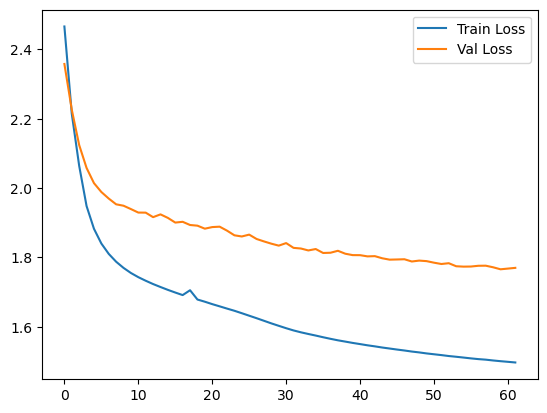

In [18]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.arange(len(global_train_loss)), global_train_loss, label="Train Loss")
plt.plot(np.arange(len(global_val_loss)), global_val_loss, label="Val Loss")
plt.legend()
plt.show()

In [19]:
def generate_output(model, x, block_size, num_tokens=100):
    result = []
    for _ in range(num_tokens):
        logits = model(x) # logits is B, T, C
        logits_last_time_step = logits[:, -1, :]

        batch_probs = F.softmax(logits_last_time_step, dim=1)
        batch_next_ch = torch.multinomial(batch_probs, 1)
        result.append(batch_next_ch.item())
        
        x = torch.cat((x, batch_next_ch), dim=1) # B, T+1
        if x.shape[1] > block_size:
            x = x[:, 1:block_size+1]
            
    return result

In [23]:
model.train()
empty_token = torch.zeros((1, 1), dtype=torch.long, device=device)
out = generate_output(model=model, x=empty_token, block_size=block_size, num_tokens=400)
print("".join(decode(out)))

On of was of yor stand seped have,
There.
BISHOOOP OF Y:

Seethough-py way!

DUE:
NCOwFers, if, I say!
Namelps take: not so the put compecty
Is sten to whetwast ing my sow: that can?
Hows I we'll live fors proclame
Whose to lew-wover.
Hath lowiger cownderen, 'Cot, Plitlos!
Welconfe nat, shex, so that vagain,nting have foor

JUJULIET:
Welcomeas.

CLAULET:
Hy nay can catusel you a chilu, was mew;
Sp
